In [2]:
import re
import unicodedata
import pandas as pd
import nltk

import env 

In [3]:
url = env.get_db_url('spam_db')
sql = '''SELECT *
        FROM spam'''
df = pd.read_sql(sql, url, index_col= 'id')

df.head()

In [6]:
additional_stopwords = ['r', 'u', '2', 'ltgt']

In [8]:
def clean(text):
    'copying cleaning function from curriculum'
    additional_stopwords = ['r', 'u', '2', 'ltgt']    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + additional_stopwords
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '',text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

#### determine how many messages are spam compared to ham

In [9]:
'''
from pd, constructs and concats two numpy arrays into one dataframe named 'labels', 
one with the count of values from the pd.labels column
the other the percentage of values from pd.labels column
'''

labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n','percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


#### make function to get figures for counts of one outcome compared to another

In [17]:
def show_counts_and_ratios(df, column):
    '''
    from pd, constructs and concats two numpy arrays into one dataframe which is returned, 
    one with the count of values from df.column
    the other the percentage of values from df.column
    '''
    labels = pd.concat([df[column].value_counts(),
                        df[column].value_counts(normalize=True)], axis =1)
    labels.columns = ['count', 'percent']
    
    return labels

In [18]:
show_counts_and_ratios(df, 'label')

,count,percent
ham,4825,0.865937
spam,747,0.134063


#### splitting our dataframe into text file with words from each type of message -> spam or ham

In [19]:
ham_words = clean(' '.join(df[df['label'] == 'ham'].text))
spam_words = clean(' '.join(df[df['label'] == 'spam'].text))
all_words = clean(' '.join(df.text))

#### getting a series of value counts for each category of message 

In [20]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [21]:
spam_freq.head(10)

call      359
free      216
txt       150
ur        144
text      137
mobile    135
4         119
claim     115
stop      113
reply     102
dtype: int64

In [23]:
ham_freq.shape, spam_freq.shape, all_freq.shape

((6982,), (2814,), (8900,))

In [24]:
word_counts = (pd.concat([ham_freq, spam_freq, all_freq], axis =1, sort = True)
               .set_axis(['ham', 'spam', 'all'], axis=1, inplace = False)
               .fillna(0)
               .apply(lambda s: s.astype(int)))

word_counts.head()

,ham,spam,all
0,0,3,3
008704050406,0,2,2
0089my,0,1,1
0121,0,1,1
01223585236,0,1,1


In [28]:
word_counts = word_counts[['all', 'ham', 'spam']]
word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


#### which words occured most frequently?

In [29]:
word_counts.sort_values(by= 'all', ascending = False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [31]:
uniquely_used = pd.concat([word_counts[word_counts['spam'] == 0].sort_values(by='ham').tail(10),
                           word_counts[word_counts['ham'] == 0].sort_values(by='spam').tail(10)])
uniquely_used

,all,ham,spam
didnt,79,79,0
amp,82,82,0
said,86,86,0
ask,88,88,0
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0


<div class = 'alert alert-block alert-info'>
    
# Vizualization

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs ham for the 20 most common words')

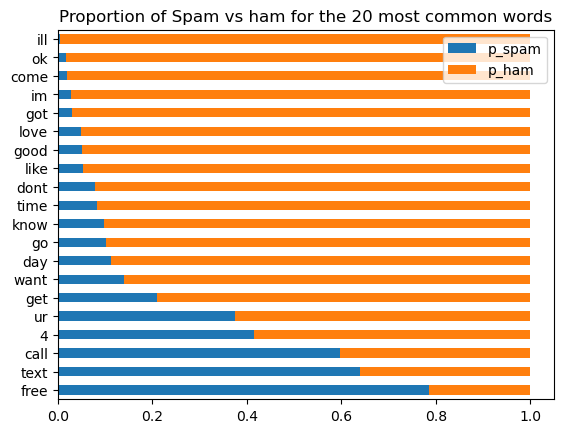

In [33]:
(word_counts.assign(
                p_spam=word_counts['spam'] / word_counts['all'],
                p_ham =word_counts['ham']  / word_counts['all'])
            .sort_values(by = 'all')
            [['p_spam', 'p_ham']]
            .tail(20)
            .sort_values('p_ham')
            .plot.barh(stacked = True))

plt.title('Proportion of Spam vs ham for the 20 most common words')

<div class = 'alert alert-block alert-info'>
    
# Skip to Bigrams

In [38]:
import acquire as ac

In [39]:
df = ac.scrape_codeup()
df.head()

,url,num
title,,
Home,https://codeup.com/,Launch Your Career in tech.\n\nGo from no expe...
San Antonio,https://codeup.com/san-antonio-events/,Workshops & Events | San Antonio\nEver wanted ...
Dallas,https://codeup.com/dallas-events/,Workshops & Events | Dallas\nEver wanted to le...
Financial Aid,https://codeup.com/financial-aid/,"Investing in your future\nSelf-Pay, Loans, Gra..."
Military,https://codeup.com/veterans/,Our Mission is To Create Life Change\nSupporti...


In [130]:
bigrams = nltk.ngrams(df['num'][4].split(), 2)
trigrams = nltk.ngrams(df['num'][4].split(), 3)

In [131]:
bigram_df = pd.DataFrame({'bigrams' : bigrams})
trigram_df = pd.DataFrame({'trigrams' : trigrams})

In [118]:
bigram_df.head()

,bigrams
0,"(Our, Mission)"
1,"(Mission, is)"
2,"(is, To)"
3,"(To, Create)"
4,"(Create, Life)"


In [132]:
trigram_df.head()

,trigrams
0,"(Our, Mission, is)"
1,"(Mission, is, To)"
2,"(is, To, Create)"
3,"(To, Create, Life)"
4,"(Create, Life, Change)"


In [133]:
top_20_codeup_military_bigrams = (bigram_df['bigrams']).value_counts().head(20)
top_20_codeup_military_trigrams = (trigram_df['trigrams']).value_counts().head(20)

In [120]:
top_20_codeup_military_bigrams

(in, the)            6
(Course, Details)    3
(of, your)           2
(VA, benefits)       2
(VET, TEC,)          2
(VET, TEC)           2
(TEC, and)           2
(After, serving)     2
(as, a)              2
(work, through)      2
(VA, Benefits)       2
(months, of)         2
(veterans, and)      2
(serving, in)        2
(the, skills)        2
(GI, Bill®)          2
(GI, Bill®,)         2
(through, your)      2
(a, copy)            1
(We, love)           1
Name: bigrams, dtype: int64

In [134]:
top_20_codeup_military_trigrams

(VET, TEC, and)                         2
(serving, in, the)                      2
(Our, Mission, is)                      1
(as, well, as)                          1
(as, a, copy)                           1
(a, copy, of)                           1
(copy, of, your)                        1
(of, your, Certificate)                 1
(your, Certificate, of)                 1
(Certificate, of, Eligibility.)         1
(of, Eligibility., Veteran)             1
(Eligibility., Veteran, Scholarship)    1
(Veteran, Scholarship, We)              1
(Scholarship, We, love)                 1
(We, love, our)                         1
(love, our, Military)                   1
(our, Military, City,)                  1
(well, as, a)                           1
(enroll, form,, as)                     1
(form,, as, well)                       1
Name: trigrams, dtype: int64

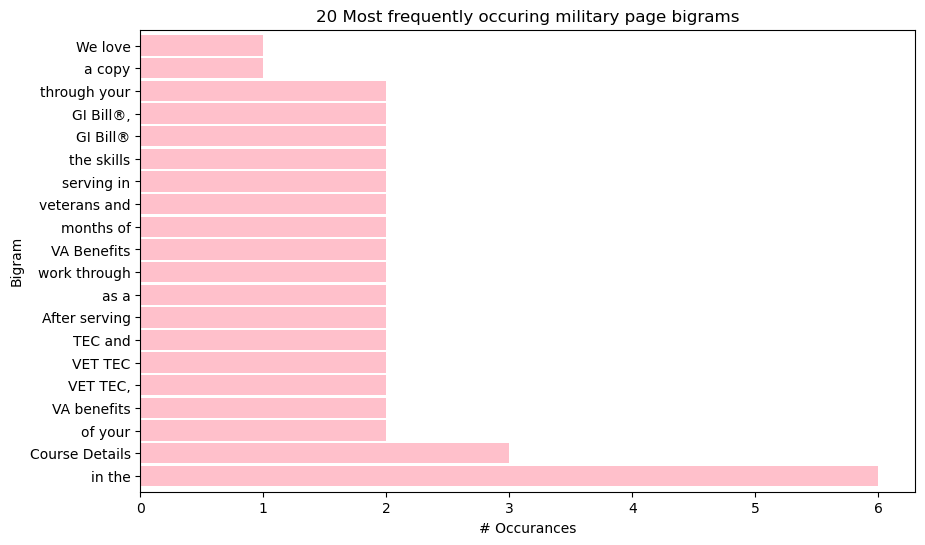

In [135]:
top_20_codeup_military_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring military page bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_codeup_military_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [123]:
top_20_codeup_military_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring military page bigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_codeup_military_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

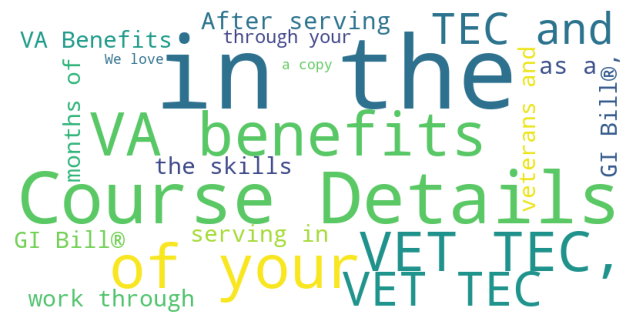

In [124]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_codeup_military_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [126]:
mem = df.memory_usage(index=True, deep=True)
total_size = sum(mem)

In [128]:
print(f'{total_size/1000000:.2f} MB')

0.42 MB


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, Home to Accessibility
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     65 non-null     object
 1   num     65 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB
